In [1]:
# Install necessary libraries for the project
!pip install torch torchvision pandas datasets kagglehub torchmetrics tqdm seaborn -q

# --- Imports and Setup ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms, models
import kagglehub
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Import the correct metrics for BINARY classification
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 9.0 MB/s eta 0:00:00


In [2]:
# --- 1. Download the dataset using KaggleHub ---
print("Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print(f"Dataset downloaded to: {dataset_path}")

# --- 2. Load the data from the local folder structure ---
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

print(f"\nLoading images from local directories...")
dataset = load_dataset(
    'imagefolder',
    data_files={
        'train': f"{train_dir}/**",
        'test': f"{test_dir}/**"
    }
)

# --- 3. Verify the loaded dataset ---
print("\nDataset loaded successfully!")
print(dataset)

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Dataset downloaded to: /kaggle/input/cifake-real-and-ai-generated-synthetic-images

Loading images from local directories...


Resolving data files:   0%|          | 0/100000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20000 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]


Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 20000
    })
})


In [3]:
# --- 3.1 Define Image Transformations ---
def get_transforms(image_size=380): # Optimal size for EfficientNet-B4
    """Returns a dictionary of data transforms."""
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(image_size + 20),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    return {'train': train_transforms, 'val': val_transforms}

# --- 3.2 Apply Transforms and Create DataLoaders ---
image_transforms = get_transforms()

def apply_train_transforms(batch):
    batch['pixel_values'] = [image_transforms['train'](img.convert("RGB")) for img in batch['image']]
    return batch

def apply_val_transforms(batch):
    batch['pixel_values'] = [image_transforms['val'](img.convert("RGB")) for img in batch['image']]
    return batch

dataset['train'].set_transform(apply_train_transforms)
dataset['test'].set_transform(apply_val_transforms)

def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['label'] for example in examples], dtype=torch.float32).unsqueeze(1)
    return {'pixel_values': pixel_values, 'labels': labels}

batch_size = 32 # Smaller batch size for larger images
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

print(f"Data preprocessing complete.")
print(f"Created Train DataLoader with {len(train_loader)} batches of size {batch_size}")
print(f"Created Test DataLoader with {len(test_loader)} batches of size {batch_size}")

Data preprocessing complete.
Created Train DataLoader with 3125 batches of size 32
Created Test DataLoader with 625 batches of size 32


In [4]:
# --- 4. Define the New EfficientNet-B4 Model ---
def build_model(pretrained=True):
    """Builds a pre-trained EfficientNet-B4 model for transfer learning."""
    weights = models.EfficientNet_B4_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b4(weights=weights)

    # Freeze all the feature-extracting layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer for our BINARY classification task (1 output)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1)

    return model

# --- Instantiate the model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)

print("Model architecture defined using EfficientNet-B4:")
print(f"Model moved to device: {device}")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 98.5MB/s]


Model architecture defined using EfficientNet-B4:
Model moved to device: cuda


In [5]:
# --- 5. Setup for Training ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

accuracy = BinaryAccuracy().to(device)
precision_metric = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
f1_score = BinaryF1Score().to(device)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc="Training")

    for batch in progress_bar:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    return running_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    accuracy.reset(); precision_metric.reset(); recall.reset(); f1_score.reset()

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(outputs)
            accuracy.update(preds, labels.int())
            precision_metric.update(preds, labels.int())
            recall.update(preds, labels.int())
            f1_score.update(preds, labels.int())

    avg_loss = running_loss / len(loader)
    acc = accuracy.compute()
    prec = precision_metric.compute()
    rec = recall.compute()
    f1 = f1_score.compute()

    return avg_loss, acc, prec, rec, f1

In [6]:
# --- 6. Main Training Loop ---
num_epochs = 5
best_val_f1 = 0.0

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")

    val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, test_loader, criterion)
    print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f}")
    print(f"Validation -> Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1-Score: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_cifake_model.pth")
        print(f"New best model saved with F1-Score: {best_val_f1:.4f}")

print("\n--- Training Finished ---")


--- Epoch 1/5 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1 Training Loss: 0.4944


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 0.3934
Validation -> Accuracy: 0.8321, Precision: 0.8618, Recall: 0.7910, F1-Score: 0.8249
New best model saved with F1-Score: 0.8249

--- Epoch 2/5 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2 Training Loss: 0.4629


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 0.3802
Validation -> Accuracy: 0.8378, Precision: 0.8849, Recall: 0.7765, F1-Score: 0.8272
New best model saved with F1-Score: 0.8272

--- Epoch 3/5 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3 Training Loss: 0.4590


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 0.3653
Validation -> Accuracy: 0.8428, Precision: 0.8738, Recall: 0.8012, F1-Score: 0.8359
New best model saved with F1-Score: 0.8359

--- Epoch 4/5 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.4595


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 0.3607
Validation -> Accuracy: 0.8479, Precision: 0.8780, Recall: 0.8080, F1-Score: 0.8415
New best model saved with F1-Score: 0.8415

--- Epoch 5/5 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.4562


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 0.3579
Validation -> Accuracy: 0.8486, Precision: 0.8894, Recall: 0.7961, F1-Score: 0.8402

--- Training Finished ---


## Cell 7: Comprehensive Model Evaluation

Loading the CIFAKE dataset...
Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.


Resolving data files:   0%|          | 0/100000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20000 [00:00<?, ?it/s]

Dataset loaded successfully.
Test data loader created.
Successfully loaded 'best_cifake_model.pth'
Running evaluation on the entire test set...


Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]


CLASSIFICATION REPORT
                precision    recall  f1-score   support

REAL (Class 0)       0.82      0.89      0.85     10000
FAKE (Class 1)       0.88      0.81      0.84     10000

      accuracy                           0.85     20000
     macro avg       0.85      0.85      0.85     20000
  weighted avg       0.85      0.85      0.85     20000


CONFUSION MATRIX


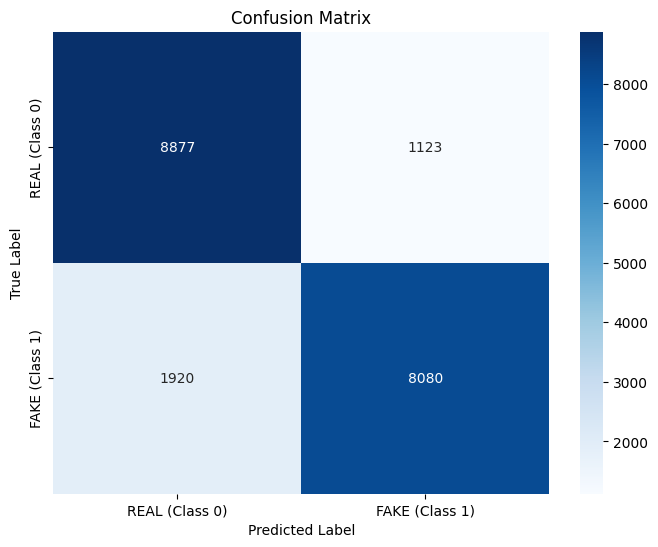

In [9]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, matthews_corrcoef
from sklearn.calibration import calibration_curve
import time
from tqdm.notebook import tqdm
from datasets import load_dataset

# --- 1. Load the Dataset ---
print("Loading the CIFAKE dataset...")
dataset_path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
dataset = load_dataset('imagefolder', data_files={'train': f"{train_dir}/**", 'test': f"{test_dir}/**"})
print("Dataset loaded successfully.")

# --- 2. Define Preprocessing and Create DataLoaders ---
def get_transforms(image_size=380):
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    return transforms.Compose([
        transforms.Resize(image_size + 20),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

def apply_transforms(batch):
    batch['pixel_values'] = [get_transforms()(img.convert("RGB")) for img in batch['image']]
    return batch

dataset['test'].set_transform(apply_transforms)

def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['label'] for example in examples], dtype=torch.float32).unsqueeze(1)
    return {'pixel_values': pixel_values, 'labels': labels}

test_loader = DataLoader(dataset['test'], batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2)
print("Test data loader created.")

# --- 3. Define the Model Architecture ---
def build_model(pretrained=True):
    weights = models.EfficientNet_B4_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b4(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1)
    return model

# --- 4. Load the Best Trained Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)
try:
    model_path = "best_cifake_model.pth"
    model.load_state_dict(torch.load(model_path))
    print(f"Successfully loaded '{model_path}'")
except FileNotFoundError:
    print(f"Error: '{model_path}' not found. Please ensure the model was trained and saved.")
model.eval()

# --- 5. Get All Predictions from the Test Set ---
all_labels, all_preds, all_probs = [], [], []
print("Running evaluation on the entire test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels']
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu()
        preds = (probs > 0.5).int()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.numpy())

all_labels = np.array(all_labels).flatten()
all_preds = np.array(all_preds).flatten()
all_probs = np.array(all_probs).flatten()

# --- 6. Display All Metrics and Plots ---
print("\n" + "="*50 + "\nCLASSIFICATION REPORT\n" + "="*50)
target_names = ['REAL (Class 0)', 'FAKE (Class 1)']
print(classification_report(all_labels, all_preds, target_names=target_names))

print("\n" + "="*50 + "\nCONFUSION MATRIX\n" + "="*50)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix')
plt.show()

## Code for Advanced Metrics


DISTRIBUTION OF PREDICTED PROBABILITIES


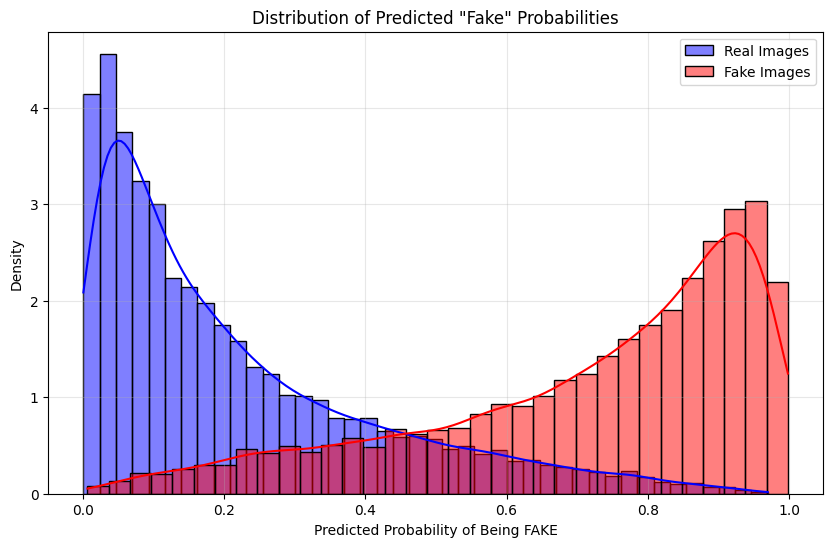


ADDITIONAL PROBABILISTIC SCORES (Lower is Better)
Log Loss: 0.3607
Brier Score: 0.1116

PERFORMANCE AT OPTIMAL F1-THRESHOLD
Optimal Threshold found: 0.4270

Classification Report (at Optimal Threshold):
              precision    recall  f1-score   support

        REAL       0.85      0.84      0.85     10000
        FAKE       0.85      0.85      0.85     10000

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000

Confusion Matrix (at Optimal Threshold):


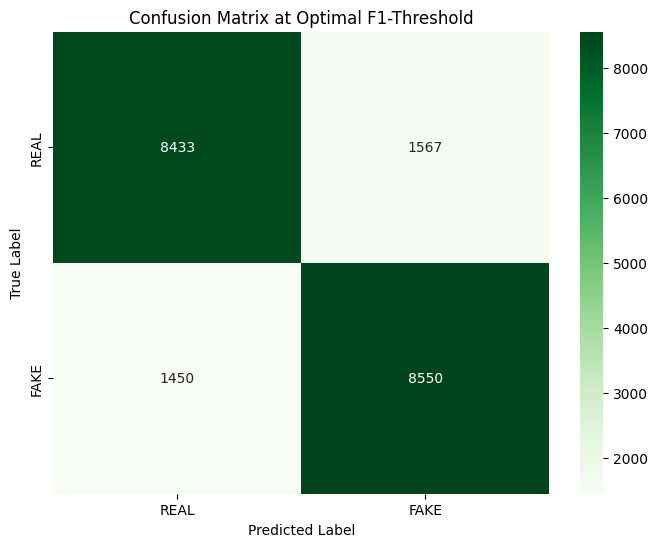

In [10]:
from sklearn.metrics import log_loss, brier_score_loss

# --- 1. Plot Distribution of Predicted Probabilities ---
print("\n" + "="*50)
print("DISTRIBUTION OF PREDICTED PROBABILITIES")
print("="*50)

plt.figure(figsize=(10, 6))
# Plot histogram for the REAL class (label == 0)
sns.histplot(all_probs[all_labels == 0], kde=True, color='blue', label='Real Images', stat='density')
# Plot histogram for the FAKE class (label == 1)
sns.histplot(all_probs[all_labels == 1], kde=True, color='red', label='Fake Images', stat='density')
plt.title('Distribution of Predicted "Fake" Probabilities')
plt.xlabel('Predicted Probability of Being FAKE')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# --- 2. Calculate Additional Probabilistic Scores ---
print("\n" + "="*50)
print("ADDITIONAL PROBABILISTIC SCORES (Lower is Better)")
print("="*50)

logloss = log_loss(all_labels, all_probs)
brier = brier_score_loss(all_labels, all_probs)

print(f"Log Loss: {logloss:.4f}")
print(f"Brier Score: {brier:.4f}")


# --- 3. Evaluate Performance at the Optimal F1-Threshold ---
print("\n" + "="*50)
print("PERFORMANCE AT OPTIMAL F1-THRESHOLD")
print("="*50)

# Find the best threshold that maximizes F1 score (re-calculating from before)
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
# Calculate F1 score for each threshold, handling division by zero
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
# We slice thresholds because it has one less element than precision/recall
best_threshold = thresholds[np.argmax(f1_scores[:-1])]

print(f"Optimal Threshold found: {best_threshold:.4f}")

# Get new predictions based on the optimal threshold
optimal_preds = (all_probs > best_threshold).astype(int)

# Display the classification report and confusion matrix for the new predictions
print("\nClassification Report (at Optimal Threshold):")
print(classification_report(all_labels, optimal_preds, target_names=['REAL', 'FAKE']))

print("Confusion Matrix (at Optimal Threshold):")
cm_optimal = confusion_matrix(all_labels, optimal_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix at Optimal F1-Threshold')
plt.show()

Successfully loaded 'best_cifake_model.pth'
Fetching a random batch of images from the test set...


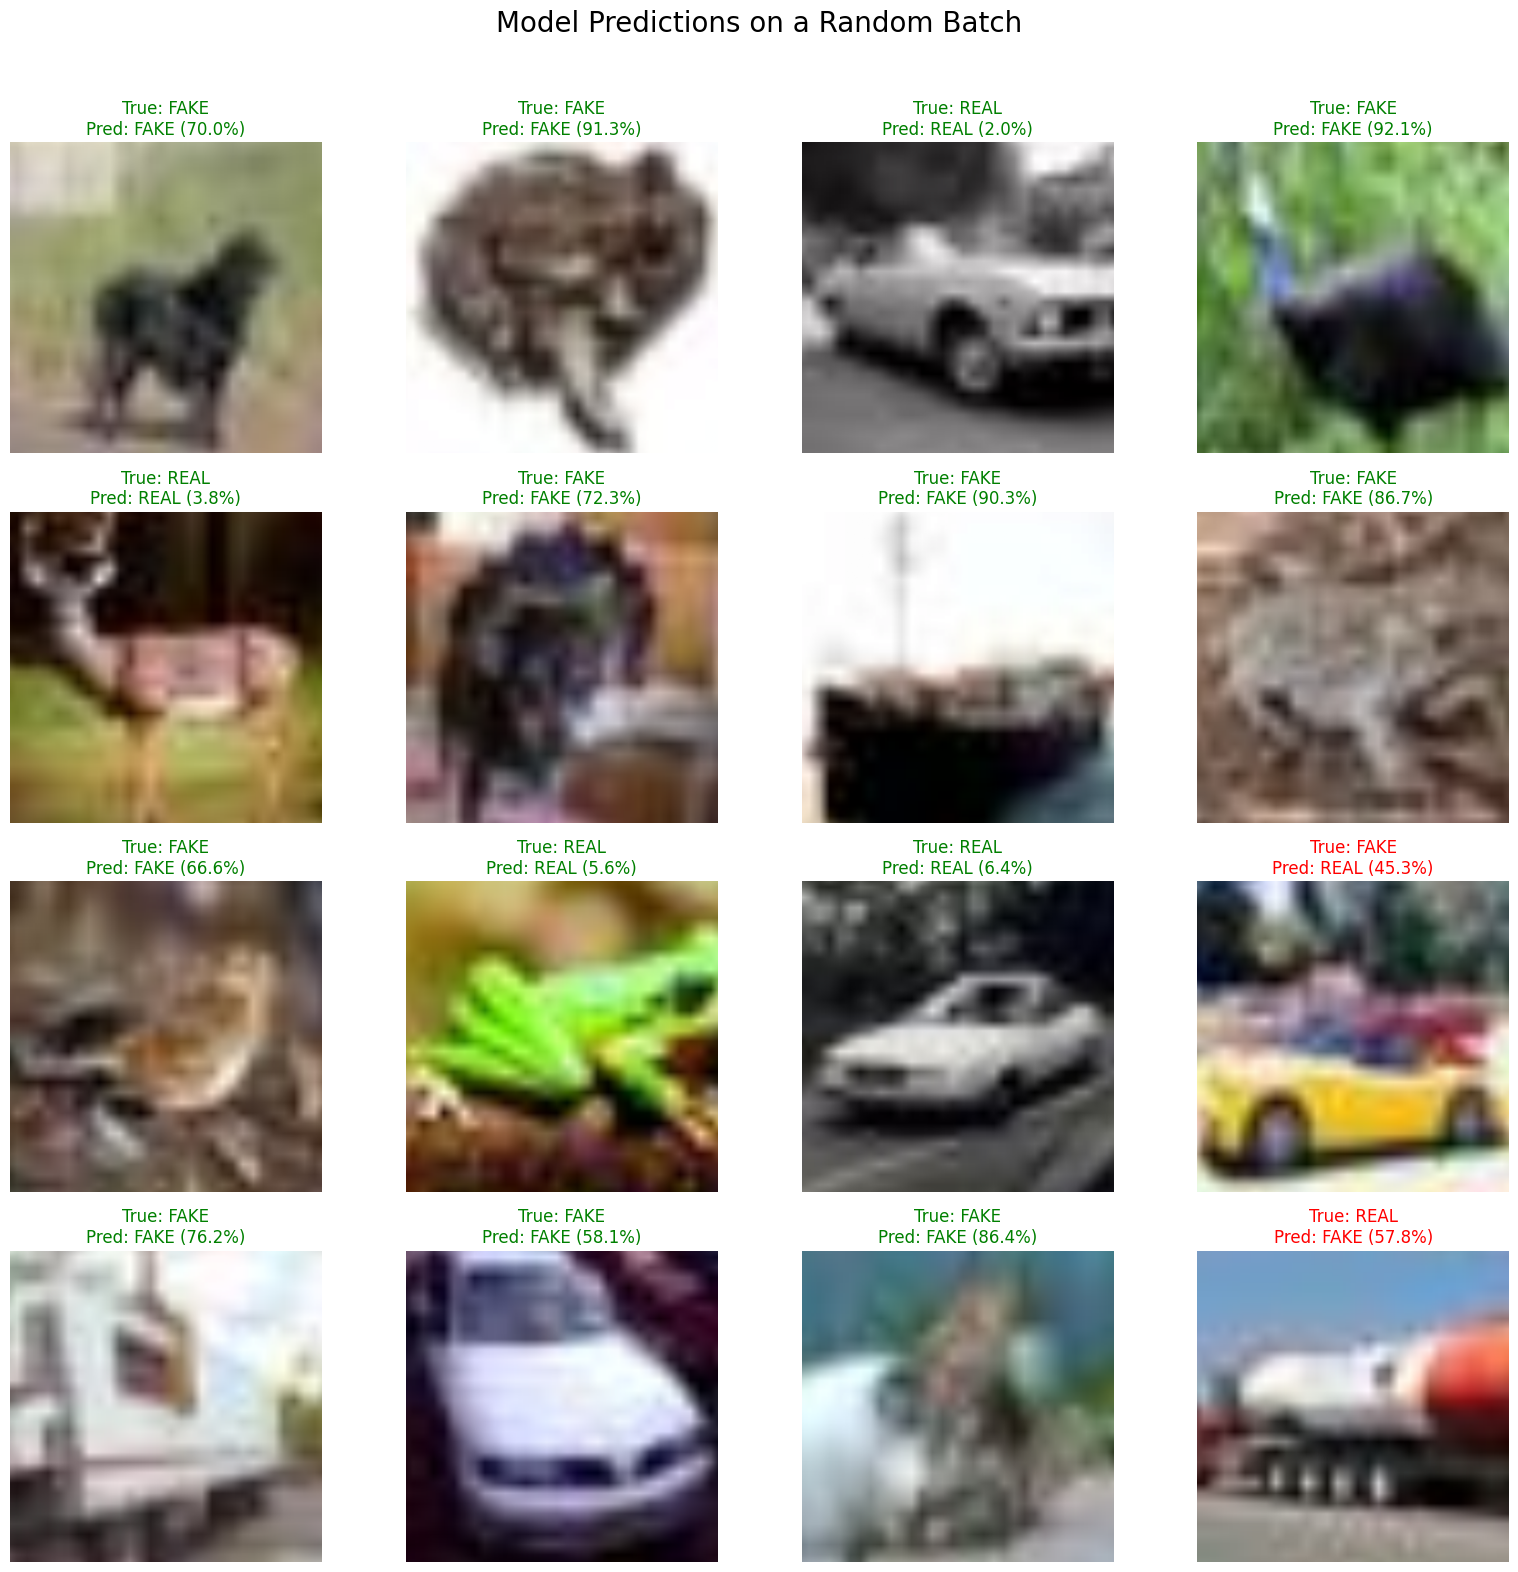

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn

# --- 1. Define Model Architecture and Denormalize Function ---
# We include these functions here to make the cell self-contained.
def build_model(pretrained=True):
    """Builds a pre-trained EfficientNet-B4 model for transfer learning."""
    weights = models.EfficientNet_B4_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b4(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1)
    return model

def denormalize(tensor):
    """Reverses the normalization on an image tensor for viewing."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    denormalized_tensor = tensor.clone()
    for t, m, s in zip(denormalized_tensor, mean, std):
        t.mul_(s).add_(m)
    return denormalized_tensor

# --- 2. Load the Best Trained Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)

try:
    model.load_state_dict(torch.load("best_cifake_model.pth"))
    print("Successfully loaded 'best_cifake_model.pth'")
except FileNotFoundError:
    print("Error: 'best_cifake_model.pth' not found. Please ensure the model was trained and saved.")
model.eval()

# --- 3. Get a Random Batch of Data ---
# Create a new, shuffled loader specifically for this visualization.
shuffled_loader = DataLoader(dataset['test'], batch_size=16, shuffle=True, collate_fn=collate_fn)
print("Fetching a random batch of images from the test set...")
batch = next(iter(shuffled_loader))

inputs = batch['pixel_values'].to(device)
labels = batch['labels'] # Keep labels on CPU for plotting

# --- 4. Make Predictions ---
with torch.no_grad():
    outputs = model(inputs)
    probs = torch.sigmoid(outputs).cpu()
    preds = (probs > 0.5).int()

# Move inputs to CPU for visualization
inputs_cpu = inputs.cpu()

# --- 5. Visualize the Results ---
label_names = {0: 'REAL', 1: 'FAKE'}
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Model Predictions on a Random Batch', fontsize=20)

for i, ax in enumerate(axes.flatten()):
    img = denormalize(inputs_cpu[i])

    true_label = label_names[int(labels[i].item())]
    pred_label = label_names[int(preds[i].item())]
    pred_confidence = probs[i].item()

    # Set title color based on correctness
    title_color = "green" if true_label == pred_label else "red"

    # PyTorch tensors are (C, H, W), Matplotlib expects (H, W, C)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(
        f"True: {true_label}\nPred: {pred_label} ({pred_confidence:.1%})",
        color=title_color,
        fontsize=12
    )
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()